In [625]:
import numpy as np
from scipy.optimize import OptimizeResult

def sgd(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.0024,
    mass=0.9,
    startiter=0,
    maxiter=500,
    callback=None,
    **kwargs
):
    x = x0
    velocity = np.zeros_like(x)

    for i in range(startiter, startiter + maxiter):
        g = jac(x)

        if callback and callback(x):
            break

        velocity = mass * velocity - (1.0 - mass) * g
        x = x + learning_rate * velocity

    i += 1
    return OptimizeResult(x=x, fun=fun(x), jac=g, nit=i, nfev=i, success=True)


def rmsprop(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.091,
    gamma=0.999,
    eps=1e-8,
    startiter=0,
    maxiter=500,
    callback=None,
    **kwargs
):
    x = x0
    avg_sq_grad = np.ones_like(x)

    for i in range(startiter, startiter + maxiter):
        g = jac(x)

        if callback and callback(x):
            break

        avg_sq_grad = avg_sq_grad * gamma + g**2 * (1 - gamma)
        x = x - learning_rate * g / (np.sqrt(avg_sq_grad) + eps)

    i += 1
    return OptimizeResult(x=x, fun=fun(x), jac=g, nit=i, nfev=i, success=True)


def adam(
    fun,
    x0,
    jac,
    args=(),
    learning_rate=0.6,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    startiter=0,
    maxiter=500,
    callback=None,
    **kwargs
):
    x = x0
    m = np.zeros_like(x)
    v = np.zeros_like(x)

    for i in range(startiter, startiter + maxiter):
        g = jac(x)

        if callback and callback(x):
            break

        m = (1 - beta1) * g + beta1 * m
        v = (1 - beta2) * (g**2) + beta2 * v
        mhat = m / (1 - beta1**(i + 1))
        vhat = v / (1 - beta2**(i + 1))
        x = x - learning_rate * mhat / (np.sqrt(vhat) + eps)

    i += 1
    return OptimizeResult(x=x, fun=fun(x), jac=g, nit=i, nfev=i, success=True)

In [626]:
def make_minimize_cb(path=[]):
    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

In [627]:
from scipy.optimize import rosen, rosen_der, minimize
from collections import defaultdict

x0 = [3., 3.]
paths_ = defaultdict(list)
paths_["SGD"].append(x0)
paths_["RMSProp"].append(x0)
paths_["Adam"].append(x0)
path_sgd_ = path_rms_ = path_adam_ = [x0]
res_sgd = minimize(rosen, x0, method=sgd, jac=rosen_der, callback=make_minimize_cb(paths_["SGD"]))
res_rms = minimize(rosen, x0, method=rmsprop, jac=rosen_der, callback=make_minimize_cb(paths_["RMSProp"]))
res_adam = minimize(rosen, x0, method=adam, jac=rosen_der, callback=make_minimize_cb(paths_["Adam"]))
paths = [np.array(paths_[method]).T for method in ["SGD", "RMSProp", "Adam"]]

print(res_sgd, res_rms, res_adam)

     fun: 0.022591782415082147
     jac: array([-0.0770658 , -0.13160312])
    nfev: 500
     nit: 500
 success: True
       x: array([0.84983808, 0.72156764])      fun: 0.004385834377365745
     jac: array([-0.06823977, -0.03439659])
    nfev: 500
     nit: 500
 success: True
       x: array([0.93379668, 0.87180435])      fun: 8.953497820454368e-05
     jac: array([-0.0095684 , -0.00473655])
    nfev: 500
     nit: 500
 success: True
       x: array([0.99054066, 0.98114716])


In [628]:
from matplotlib import animation
from itertools import zip_longest

class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [629]:
from collections import defaultdict

xmin, xmax, xstep = -1, 2, .2
ymin, ymax, ystep = 0, 2, .2

XY = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = rosen(XY)
minima = np.array([1., 1.])
minima_ = minima.reshape(-1, 1)

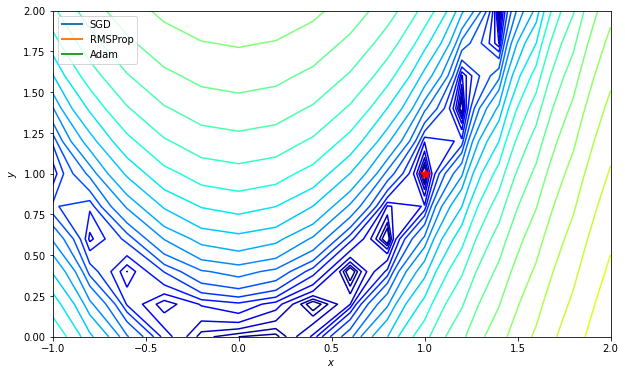

In [630]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(XY[0], XY[1], z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=["SGD", "RMSProp", "Adam"], ax=ax)

ax.legend(loc='upper left')

In [631]:
from IPython.display import HTML

HTML(anim.to_html5_video())

In [ ]:
x0 = [-1., 2.]
paths_ = defaultdict(list)
paths_["SGD"].append(x0)
paths_["RMSProp"].append(x0)
paths_["Adam"].append(x0)
path_sgd_ = path_rms_ = path_adam_ = [x0]
res_sgd = minimize(rosen, x0, method=sgd, jac=rosen_der, callback=make_minimize_cb(paths_["SGD"]))
res_rms = minimize(rosen, x0, method=rmsprop, jac=rosen_der, callback=make_minimize_cb(paths_["RMSProp"]))
res_adam = minimize(rosen, x0, method=adam, jac=rosen_der, callback=make_minimize_cb(paths_["Adam"]))
paths = [np.array(paths_[method]).T for method in ["SGD", "RMSProp", "Adam"]]

print(res_sgd, res_rms, res_adam)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(XY[0], XY[1], z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=["SGD", "RMSProp", "Adam"], ax=ax)

ax.legend(loc='upper left')

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
x0 = [2., 0.]
paths_ = defaultdict(list)
paths_["SGD"].append(x0)
paths_["RMSProp"].append(x0)
paths_["Adam"].append(x0)
path_sgd_ = path_rms_ = path_adam_ = [x0]
res_sgd = minimize(rosen, x0, method=sgd, jac=rosen_der, callback=make_minimize_cb(paths_["SGD"]))
res_rms = minimize(rosen, x0, method=rmsprop, jac=rosen_der, callback=make_minimize_cb(paths_["RMSProp"]))
res_adam = minimize(rosen, x0, method=adam, jac=rosen_der, callback=make_minimize_cb(paths_["Adam"]))
paths = [np.array(paths_[method]).T for method in ["SGD", "RMSProp", "Adam"]]

print(res_sgd, res_rms, res_adam)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(XY[0], XY[1], z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=["SGD", "RMSProp", "Adam"], ax=ax)

ax.legend(loc='upper left')

In [ ]:
HTML(anim.to_html5_video())

     fun: 0.4101770581190842
     jac: array([-0.82953685, -0.63385583])
    nfev: 500
     nit: 500
 success: True
       x: array([0.36033066, 0.1266756 ])      fun: 4.000184121345887
     jac: array([-2.63051304,  0.68479069])
    nfev: 500
     nit: 500
 success: True
       x: array([-0.99975312,  1.00292914])      fun: 0.00017277572340786268
     jac: array([-0.01000881, -0.00839904])
    nfev: 500
     nit: 500
 success: True
       x: array([0.98686214, 0.97385537])


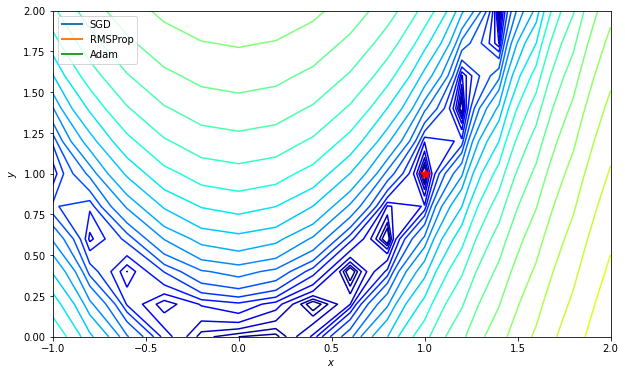

In [633]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(XY[0], XY[1], z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=["SGD", "RMSProp", "Adam"], ax=ax)

ax.legend(loc='upper left')

In [634]:
HTML(anim.to_html5_video())

In [635]:
x0 = [2., 0.]
paths_ = defaultdict(list)
paths_["SGD"].append(x0)
paths_["RMSProp"].append(x0)
paths_["Adam"].append(x0)
path_sgd_ = path_rms_ = path_adam_ = [x0]
res_sgd = minimize(rosen, x0, method=sgd, jac=rosen_der, callback=make_minimize_cb(paths_["SGD"]))
res_rms = minimize(rosen, x0, method=rmsprop, jac=rosen_der, callback=make_minimize_cb(paths_["RMSProp"]))
res_adam = minimize(rosen, x0, method=adam, jac=rosen_der, callback=make_minimize_cb(paths_["Adam"]))
paths = [np.array(paths_[method]).T for method in ["SGD", "RMSProp", "Adam"]]

print(res_sgd, res_rms, res_adam)

     fun: 0.14159435968512157
     jac: array([-0.29197025, -0.36984387])
    nfev: 500
     nit: 500
 success: True
       x: array([0.6241624 , 0.38773355])      fun: 1.6777782727974735
     jac: array([-2.35893362,  0.39722315])
    nfev: 500
     nit: 500
 success: True
       x: array([-0.29514127,  0.0890765 ])      fun: 0.027982572860750975
     jac: array([-0.16594937, -0.10214203])
    nfev: 500
     nit: 500
 success: True
       x: array([0.83279735, 0.69304303])


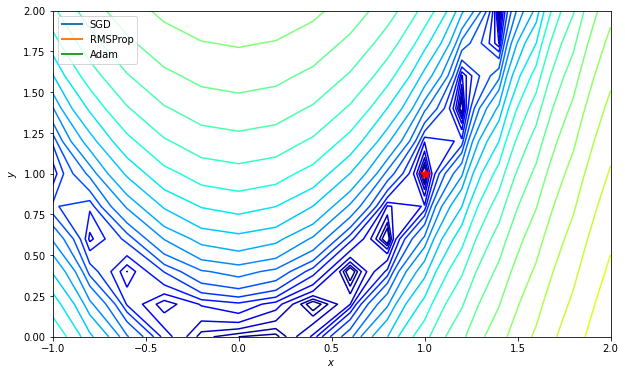

In [636]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(XY[0], XY[1], z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=["SGD", "RMSProp", "Adam"], ax=ax)

ax.legend(loc='upper left')

In [637]:
HTML(anim.to_html5_video())